# Konfio's DS challenge

This challenge is intended to test the approach take for a machine learning problem in which we have to perform many steps until finding a model that can help the business in their customer acquisition strategy base on risk

On the last step (deployment) you will need to answer the following 3 questions:

- Pick the best clients you will give a loan to, based on the model you created. It could be as complex as you decide (even as simpler as knock out rules), as long as the metrics support it
- Propose an amount to be lended to those clients and a term in which the loan will need to be paid back.
- Finally choose an anual interest rate the lended amount must have in order to be profitable.


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest

import warnings
import datetime

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor,KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier,MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score


plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

import sys
sys.path.append("../../")
sys.path.append("../")

# local imports
from learner_params import all_features, target_column
from utils.utils import (
    Benchmark,
    ROCs,
    FancyImputer,
    Class_balanced,
    Calibrated_classifier,
    PlotTime,
    BusinessUplot,
    Pieplot,
    Logtransformation,
    FeatureSelection,
    FeatureSelector,
    Plot2D,
    PlotAnomalies,
    PlotK,
    PlotClusterScore,
    PlotConfusionMatrix,
    RiskPlot
)


/var/folders/qr/1htx77yx7hqb1c_22kq9l2_w0000gn/T/ipykernel_30240/426445438.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Files loading

In [2]:
url_users='data/users.csv'
url_credit_reports='data/credit_reports.csv'
users=pd.read_csv(url_users)
creport=pd.read_csv(url_credit_reports)

### Creation/manipulation of dataframes

In [3]:
# Creating auxiliary columns and new tables
users.rename(columns={'class':'clase'},inplace=True)
users_detail=pd.merge(creport,users,left_on='user_id',right_on='id')
# users.drop(['id'],axis=1,inplace=True)
# users_detail.drop(['id'],axis=1,inplace=True)
#users['net_income']=users.monthly_income-users.monthly_outcome
users_detail['has_credit_with_us']=users_detail.institution.str.contains('KONFIO')
users_detail['payment_frequency_days']=users_detail.payment_frequency.map({'Mensual':30,'Semanal':7,'Quincenal':15,'Catorcenal':14,
                                                                'Anual':365,'Trimestral':90,'Una sola exhibición':0,'Pago mínimo para cuentas revolventes':0,'Bimestral':60,'Deducción del salario':0})
users_detail['Late']=users_detail.payment_frequency_days*users_detail.number_of_payments_due
users_detail['Late0-30']=users_detail.Late<=30
users_detail['Late31-60']=(users_detail.Late>30)*(users_detail.Late<=60)
users_detail['Late61-90']=(users_detail.Late>60)*(users_detail.Late<=90)
users_detail['Late91-120']=(users_detail.Late>90)*(users_detail.Late<=120)
users_detail['Late121-150']=(users_detail.Late>120)*(users_detail.Late<=150)
users_detail['Late151-worst']=users_detail.Late>150
users_detail['number_of_time_past_due']=users_detail.number_of_payments_due>0
users_detail['hipoteca']=users_detail.account_type=='Hipoteca'
users_detail['Revolvente']=users_detail.account_type=='Revolvente'

#Creating auxiliary tables to summarize business
our_customers_id=pd.DataFrame({'value':users_detail[(users_detail.has_credit_with_us==True)].groupby(['user_id'])['institution'].count()})
#--our_customers_id['indice']=cust.index
our_customers_id['indice']=our_customers_id.index # Fixed issue above
our_customers=users_detail[users_detail.user_id.isin(our_customers_id.indice)]
non_customers=users_detail[~users_detail.user_id.isin(our_customers_id.indice)]

# Only for pie chart
num_good_cust=users_detail[(users_detail.has_credit_with_us==True) & (users_detail.clase==1)].groupby(['user_id'])['institution'].count().shape[0]
num_bad_cust=users_detail[(users_detail.has_credit_with_us==True) & (users_detail.clase==0)].groupby(['user_id'])['institution'].count().shape[0]
num_good_non_cust=non_customers[non_customers.clase==1].groupby('user_id')['institution'].count().shape[0]
num_bad_non_cust=non_customers[non_customers.clase==0].groupby('user_id')['institution'].count().shape[0]

###For date charts##
fecha_apertura_our=[datetime.datetime.strptime(fecha, '%m/%d/%y').date() for fecha in our_customers.account_opening_date]
fecha_apertura_non=[datetime.datetime.strptime(fecha, '%m/%d/%y').date() for fecha in non_customers.account_opening_date]
our_customers.account_opening_date=pd.to_datetime(fecha_apertura_our)
our_customers['account_opening_year']=our_customers.account_opening_date.apply(lambda x: x.year)
our_customers.set_index('account_opening_date',inplace=True)
non_customers.account_opening_date=pd.to_datetime(fecha_apertura_non)
non_customers['account_opening_year']=non_customers.account_opening_date.apply(lambda x: x.year)
non_customers.set_index('account_opening_date',inplace=True)


## Business Understanding

**Insights:**
1. There is a statistically significant difference between  good and bad customers in terms of income an outcome(1) 
It should be taken into considerantion when analyzing a potential loan for a customer

2. Bad and good customers have a similar behave when it comes to net income , both tend to spend more money than the have and surprinsinly we can see that good customer ramain in average in negative nubers

3. There is a significant difference between the proportion of good customers as seen in Konfio's customers vs non customers. It seems to be a higher proportion of good customers in Konfio as compared with market(2)

(1) Acording to t-test at 99% confidence
(2) Acording to z-test at 95% confidence

In [4]:
users[['monthly_income','monthly_outcome']][users.clase==0].describe()[1:].T

,mean,std,min,25%,50%,75%,max
monthly_income,57598.982796,246794.110958,1.0,1798.0,6392.0,26213.0,3968998.0
monthly_outcome,45993.135484,333503.957721,1.0,1477.0,5779.0,22822.0,6496313.0


In [5]:
users[['monthly_income','monthly_outcome']][users.clase==1].describe()[1:].T

,mean,std,min,25%,50%,75%,max
monthly_income,177252.871028,596088.175825,14.0,4500.0,22781.0,89652.5,9344842.0
monthly_outcome,193605.448598,722308.692786,38.0,7562.5,34054.0,102071.0,9749651.0


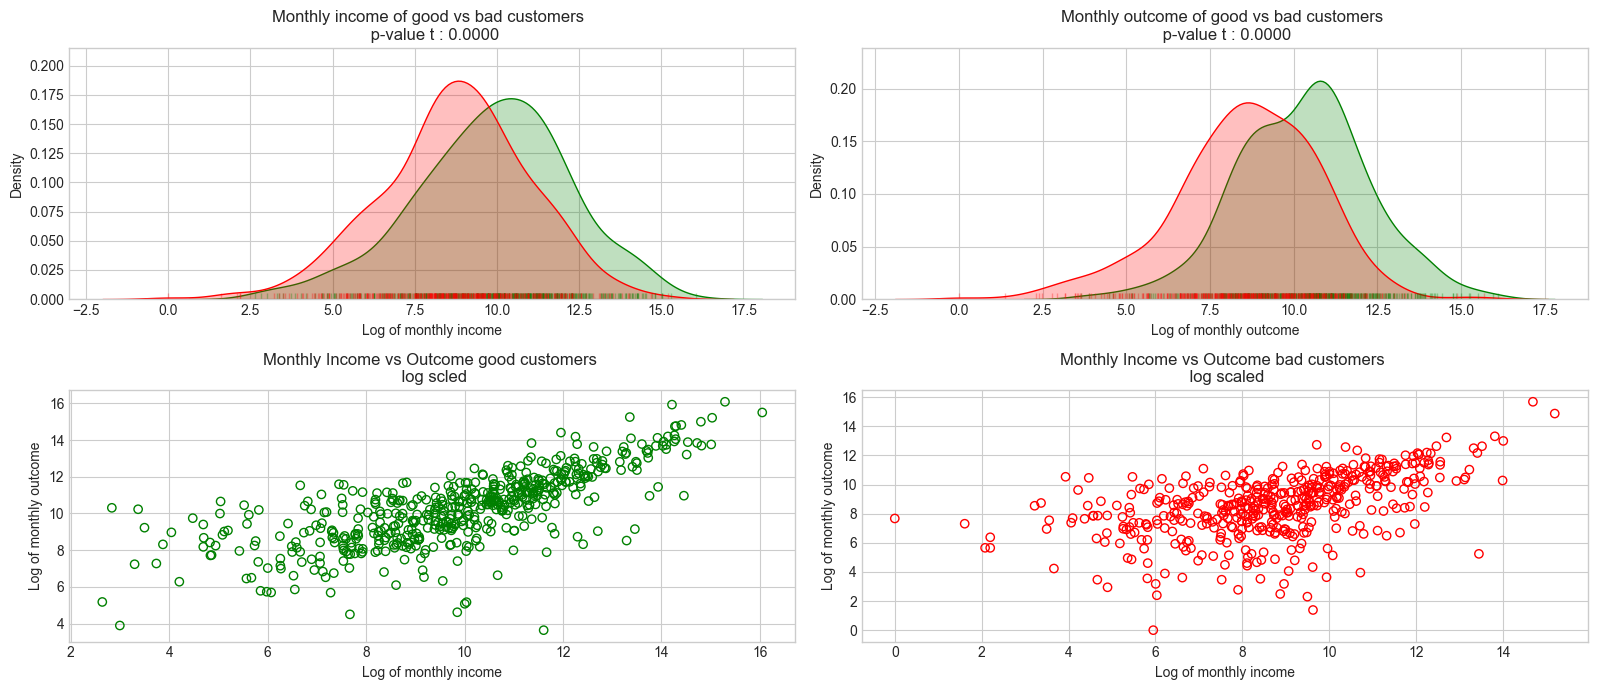

In [6]:
BusinessUplot(users,'monthly_income','monthly_outcome','clase')

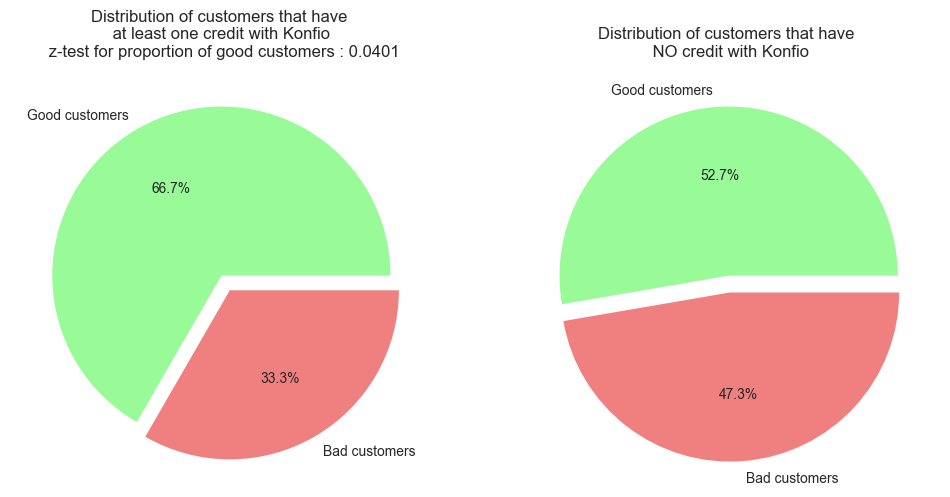

In [7]:
Pieplot(num_good_cust,num_bad_cust,num_good_non_cust,num_bad_non_cust)

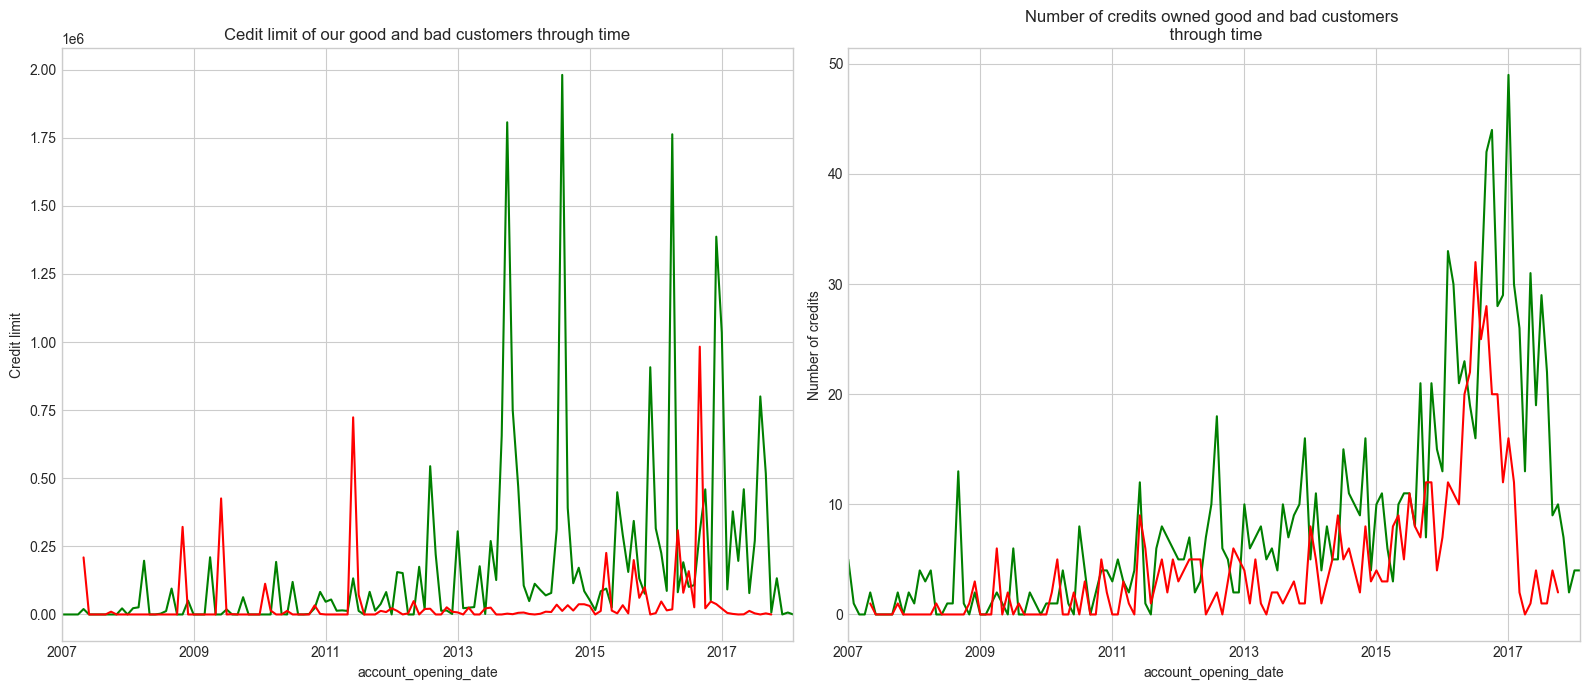

In [8]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018) & (our_customers.clase==1)].resample('M')["credit_limit"].sum().plot(color='green')
our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018)  & (our_customers.clase==0)].resample('M')["credit_limit"].sum().plot(color='red')
plt.title('Cedit limit of our good and bad customers through time')
plt.ylabel('Credit limit')
plt.subplot(1,2,2)
our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018) & (our_customers.clase==1)].resample('M')["user_id"].count().plot(color='green')
our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018)  & (our_customers.clase==0)].resample('M')["user_id"].count().plot(color='red')
plt.title('Number of credits owned good and bad customers \n through time')
plt.ylabel('Number of credits')
plt.tight_layout()

## Data Understanding

Variables' shape suggests a logaritmic scaling will be necessary in order to center our variables since most of them are skwed

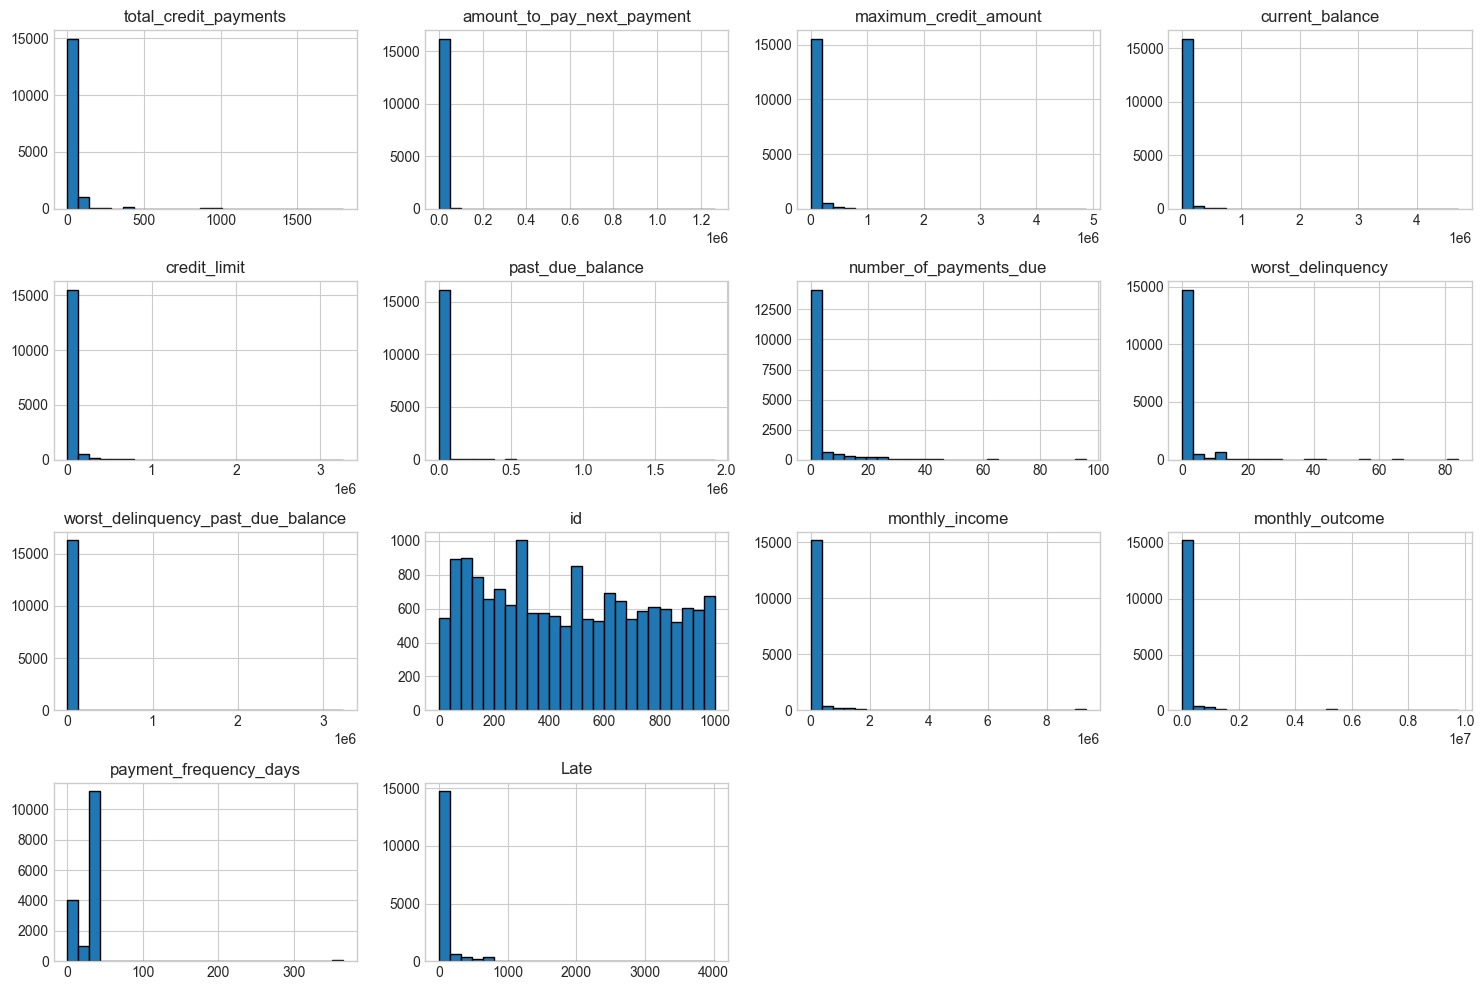

In [9]:
users_detail[users_detail.columns[~users_detail.columns.isin(['clase','user_id'])]].hist(figsize=(15,10),edgecolor='black',bins=25)
plt.tight_layout();

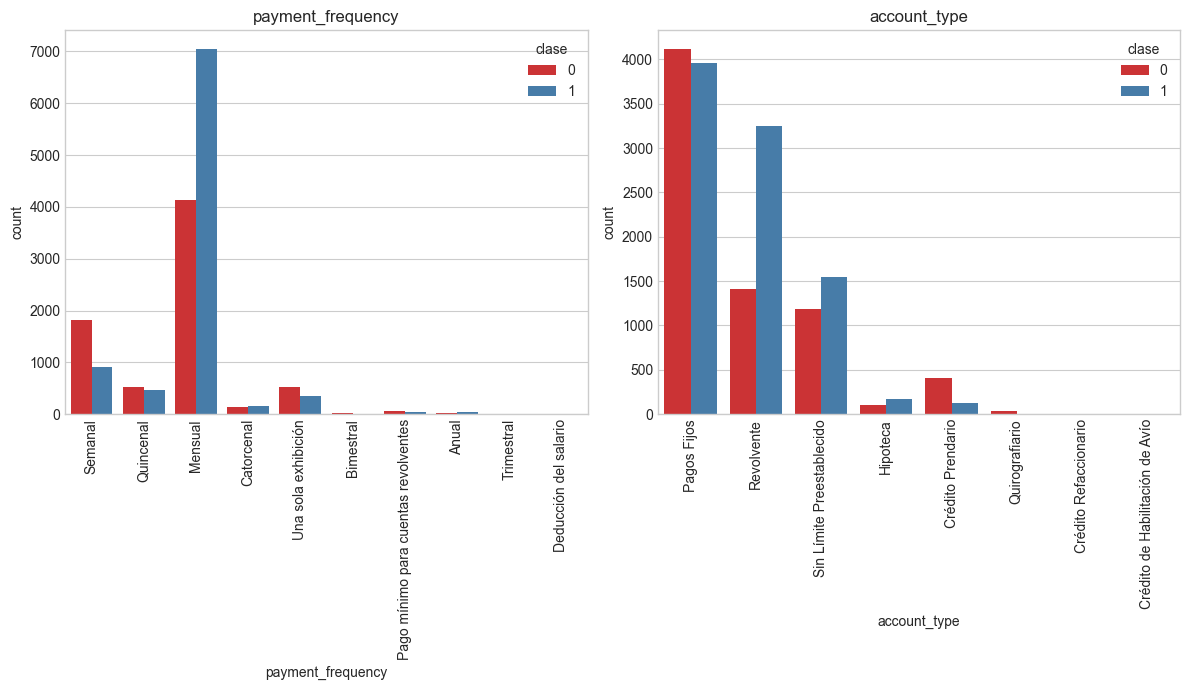

In [10]:
plt.figure(figsize=(12,7))
for i,col in enumerate(users_detail[['payment_frequency','account_type','clase']].columns[0:2]):
    plt.subplot(1,2,i+1)
    sns.countplot(data=users_detail[['payment_frequency','account_type','clase']],x=col,palette='Set1',orient='v',hue='clase')
    plt.title(str(col))
    plt.xticks(rotation=90)
plt.tight_layout();

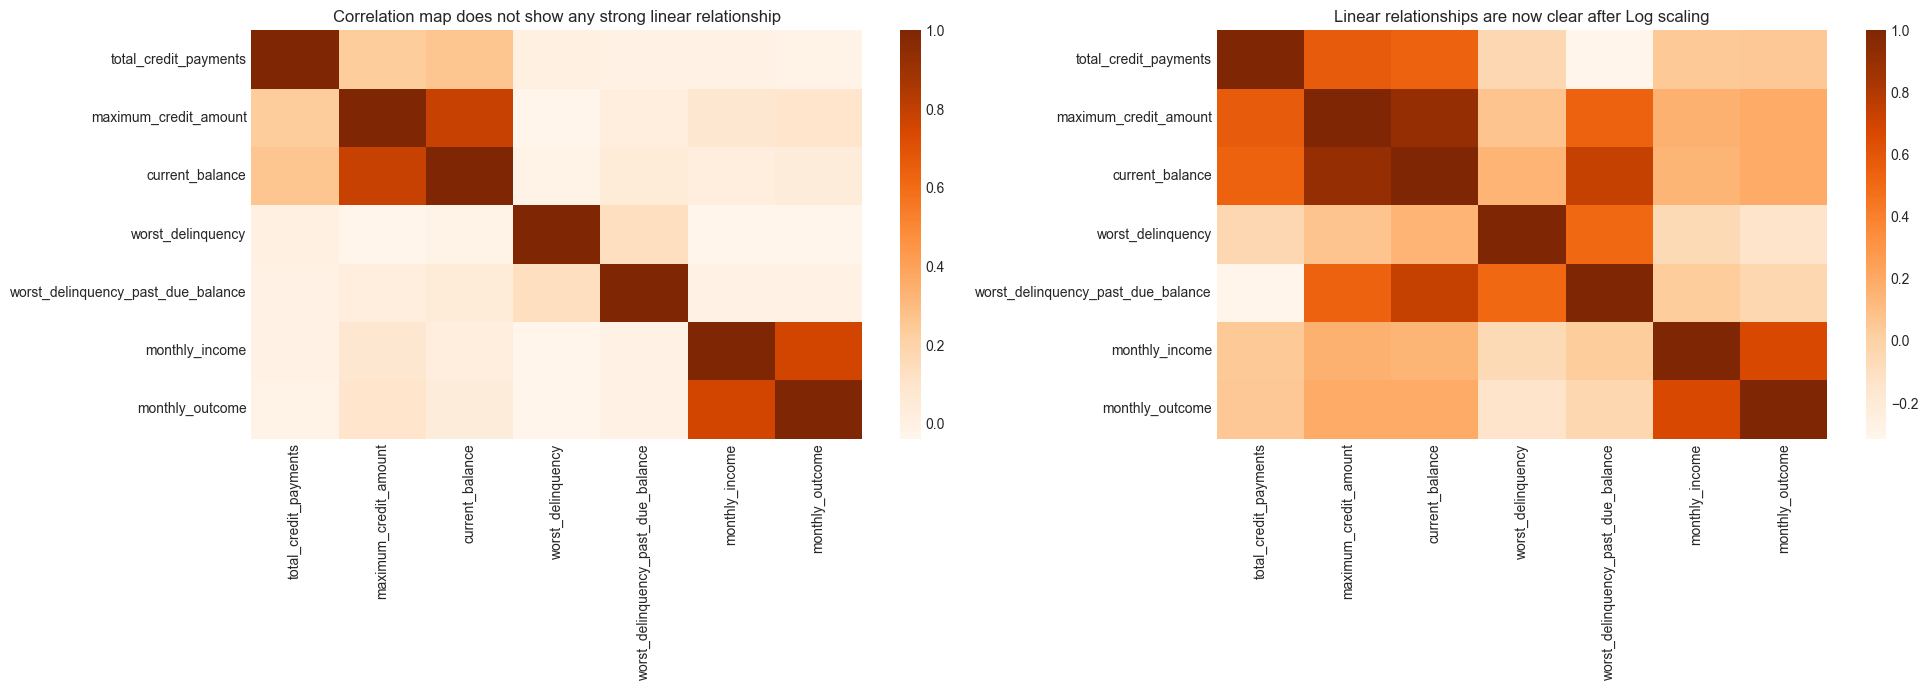

In [11]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.heatmap(users_detail[[ 'total_credit_payments','maximum_credit_amount','current_balance',
                          'worst_delinquency','worst_delinquency_past_due_balance','monthly_income','monthly_outcome']].corr(),cmap='Oranges')
plt.title('Correlation map does not show any strong linear relationship')

plt.subplot(1,2,2)
sns.heatmap(users_detail[[ 'total_credit_payments','maximum_credit_amount','current_balance',
                          'worst_delinquency','worst_delinquency_past_due_balance','monthly_income','monthly_outcome']].apply(np.log).corr(),cmap='Oranges')
plt.title('Linear relationships are now clear after Log scaling')

plt.tight_layout();

## Data Preparation
New ideally usefull variables (20) will be generated in order to generate a dataset that serves as starting point to create a model that helps to separate good and bad customers

### Variables creation

We are to generate features from credit bureau using the historical information of the customers.

Features will be creted to capture the payment ability of the customers in different time windows.

In [12]:
cliente_konfio=users_detail.groupby('user_id')['has_credit_with_us'].sum().apply(lambda x: x>0)
mean_maximum_credit_amount=users_detail.groupby('user_id')['maximum_credit_amount'].mean()
sum_current_balance=users_detail.groupby('user_id')['current_balance'].sum()
max_credit_limit=users_detail.groupby('user_id')['credit_limit'].max()
mean_worst_delinquency=users_detail.groupby('user_id')['worst_delinquency'].mean()
max_worst_delinquency=users_detail.groupby('user_id')['worst_delinquency'].max()
mean_number_payments_due=users_detail.groupby('user_id')['number_of_payments_due'].mean()
mean_past_due_balance=users_detail.groupby('user_id')['past_due_balance'].mean()
mean_worst_past_due_balance=users_detail.groupby('user_id')['worst_delinquency_past_due_balance'].mean()
number_of_times_late_0_30=users_detail.groupby('user_id')['Late0-30'].sum()
number_of_times_late_31_60=users_detail.groupby('user_id')['Late31-60'].sum()
number_of_times_late_61_90=users_detail.groupby('user_id')['Late61-90'].sum()
number_of_times_late_91_120=users_detail.groupby('user_id')['Late91-120'].sum()
number_of_times_late_121_150=users_detail.groupby('user_id')['Late121-150'].sum()
number_of_times_late_150_worst=users_detail.groupby('user_id')['Late151-worst'].sum()
number_of_open_creditlines_and_loans=users_detail.groupby('user_id')['user_id'].count()
number_of_times_past_due=users_detail.groupby('user_id')['number_of_time_past_due'].sum()
delinquencies_per_line = number_of_times_past_due/number_of_open_creditlines_and_loans
number_of_mortgages=users_detail.groupby('user_id')['hipoteca'].sum()
number_of_revolving_credits=users_detail.groupby('user_id')['Revolvente'].sum()
clase=users.clase
income=users.monthly_income
outcome=users.monthly_outcome
ratio=users.monthly_income/users.monthly_outcome

In [13]:
df=pd.DataFrame({'cliente_konfio':cliente_konfio,'mean_max_cred_amount':mean_maximum_credit_amount,
                 'sum_curr_balance':sum_current_balance,'max_cred_lim':max_credit_limit,
                 'mean_worst_del':mean_worst_delinquency,'max_worst_del':max_worst_delinquency,
                 'mean_num_paymnts_due':mean_number_payments_due,'mean_past_due_balnce':mean_past_due_balance,
                 'mean_worst_past_due_balnce':mean_worst_past_due_balance,'late_0_30':number_of_times_late_0_30,
                 'late_31_60':number_of_times_late_31_60,'late_61_90':number_of_times_late_61_90,'late_91_120':number_of_times_late_91_120,
                 'late_121_150':number_of_times_late_121_150,'late_151_worst':number_of_times_late_150_worst,
                 'num_open_cred_lines_and_loans':number_of_open_creditlines_and_loans,'number_times_past_due':number_of_times_past_due,
                 'delinq_per_line':delinquencies_per_line,'number_mortgages':number_of_mortgages,'number_revolvs':number_of_revolving_credits,'income':income,'outcome':outcome,'ratio':ratio,'clase':clase},
               )
df.cliente_konfio=df.cliente_konfio*1
df.fillna(value=0,axis=1,inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cliente_konfio                 1000 non-null   float64
 1   mean_max_cred_amount           1000 non-null   float64
 2   sum_curr_balance               1000 non-null   float64
 3   max_cred_lim                   1000 non-null   float64
 4   mean_worst_del                 1000 non-null   float64
 5   max_worst_del                  1000 non-null   float64
 6   mean_num_paymnts_due           1000 non-null   float64
 7   mean_past_due_balnce           1000 non-null   float64
 8   mean_worst_past_due_balnce     1000 non-null   float64
 9   late_0_30                      1000 non-null   float64
 10  late_31_60                     1000 non-null   float64
 11  late_61_90                     1000 non-null   float64
 12  late_91_120                    1000 non-null   float64

## Modelling
We are to take our feature engineered dataset and start exploring the process of modelling.

We will include:

1. Feature selection using recursive methods
2. Model selection with CV
3. Outliers exploration
4. Model calibration

### Feature selection

By comparing 3 different estimators as well as 3 different metrics to find the best features we can see the following:
1. Since we consider important to minimize false positives we are going to give more weight to roc_auc (true positive rate vs true negative rate)
2. Random Forest is in general having a better performace in term of the 3 metrics so it will be used as base estimator
3. By considering the facts described above we have reach the conslusion of keeping 13 variables that give us a roc_auc ~94% and a f1 ~86%

In [15]:
train_df, test_df = train_test_split(df, test_size=.3, random_state=42)

In [16]:
models=[RandomForestClassifier(n_estimators=150,random_state=123),
        XGBClassifier(random_state=123),
              ]

CPU times: user 49.8 s, sys: 10.7 s, total: 1min
Wall time: 22.6 s


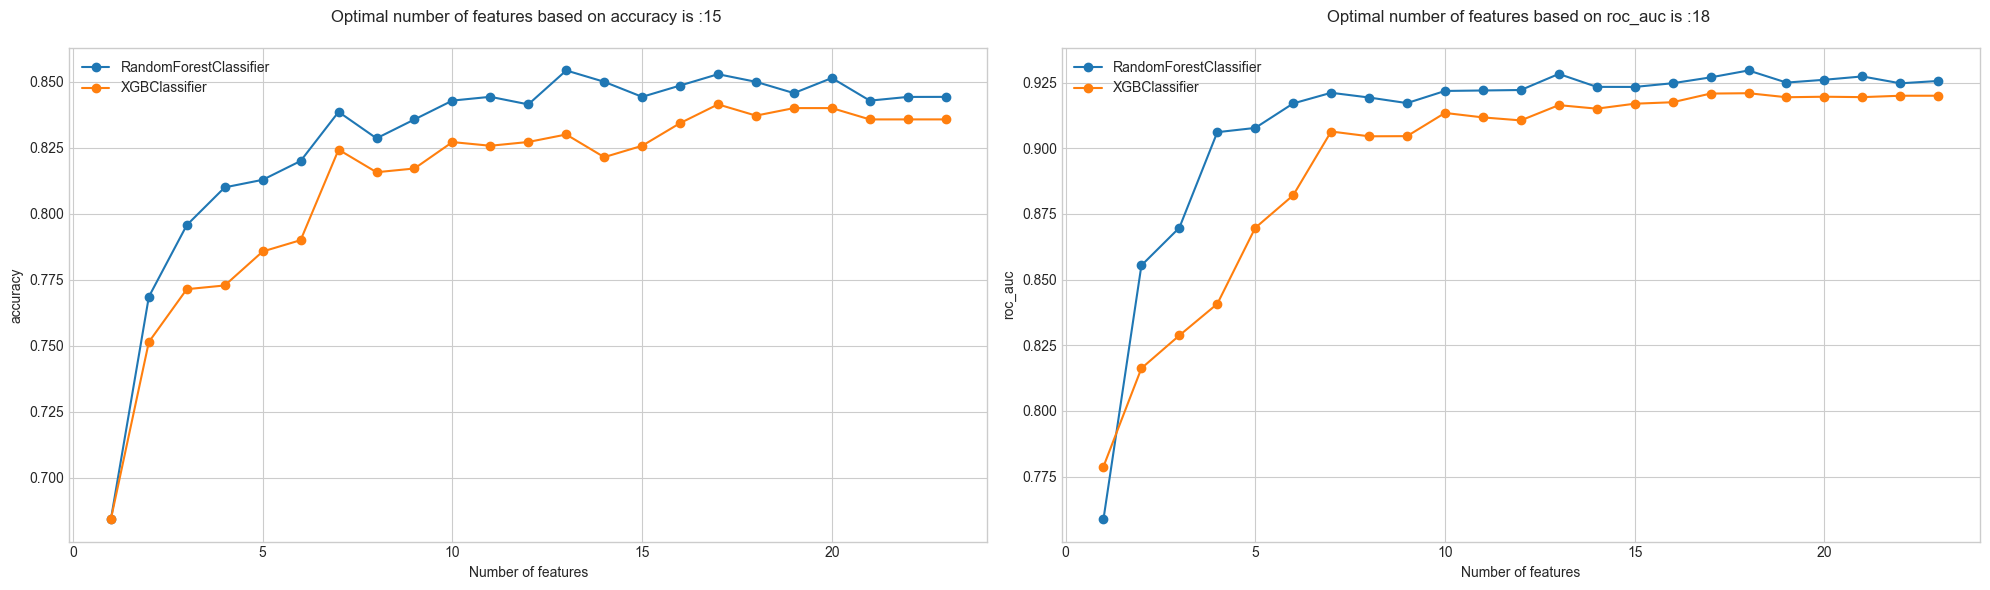

In [17]:
%%time
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
FeatureSelection(train_df[all_features],train_df[target_column],models,scorer='accuracy',steps=1)
plt.subplot(1,2,2)
FeatureSelection(train_df[all_features],train_df[target_column],models,scorer='roc_auc',steps=1)
plt.tight_layout();

In [19]:
clf = models[0]
variables_selected=FeatureSelector(train_df[all_features],
                                   train_df[target_column],
                                   clf,
                                   scorer='roc_auc',
                                   steps=1
                                  )

#### Most important variables after feature selection

After RFE we were able to reduce the feature set from 23 to 17 features while keeping a good performance. the is no dound it will help to have a more stable model and also will save time once the model is deployed and it needs to be monitored.

In [20]:
pd.DataFrame({'best variables':variables_selected})

,best variables
0,delinq_per_line
1,income
2,late_0_30
3,late_151_worst
4,max_cred_lim
5,max_worst_del
6,mean_max_cred_amount
7,mean_num_paymnts_due
8,mean_past_due_balnce
9,mean_worst_del


### Modeling
We have a classification task that will be resolved by combining tree based models along with neural nets and linear and bayesian models

### Extra
**Anomally detection**

1. On the left we have a visualization on 2D of how good and bad costumers have a "well" defined separation. this may indicate that decision boundary is not linear so it may be not adequate to use linear models
2. On the right we have a plot that shows the out and inliyers on our dataset. We see the precense of some outliers and eventhught the tree-based models are robust to that, it will be worthy to check the perfonce of a model with and without those samples.



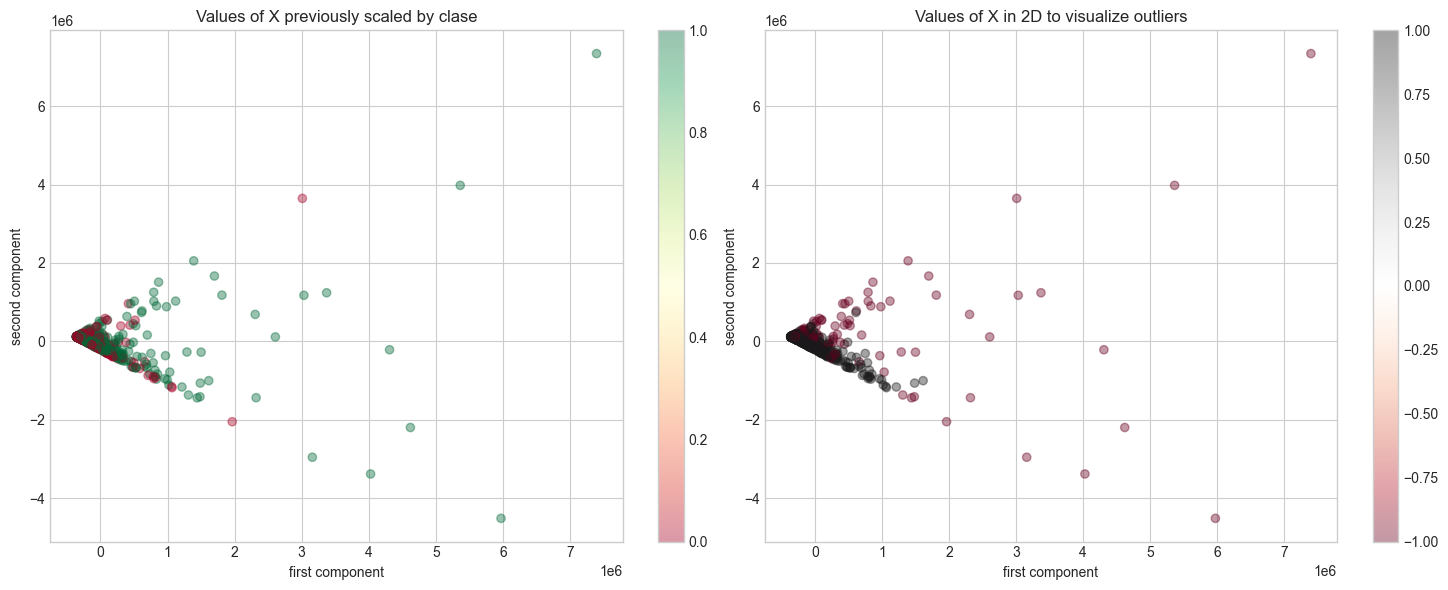

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
Plot2D(train_df[variables_selected],train_df[target_column])
plt.subplot(1,2,2)
PlotAnomalies(train_df[variables_selected])

In [22]:
outliers=PlotAnomalies(train_df[variables_selected],return_values=True)

### Model selection
We are to run CV to select among the best models the very best. We are to use ensemble of type voting.

In [23]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=150,random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

models=[SVC(probability=True,random_state=123),KNeighborsClassifier(weights='distance'),RandomForestClassifier(n_estimators=150,random_state=123),
        GaussianNB(),LogisticRegression(random_state=123),AdaBoostClassifier(n_estimators=150,random_state=123),MLPClassifier(),Voting]

CPU times: user 36.7 s, sys: 8.56 s, total: 45.3 s
Wall time: 8.09 s


,CV Score,CV Min,CV max
SVC,0.683989,0.665554,0.715852
KNeighborsClassifier,0.680497,0.612544,0.717741
RandomForestClassifier,0.926143,0.902407,0.948229
GaussianNB,0.820732,0.795950,0.845259
LogisticRegression,0.874390,0.844237,0.895556
AdaBoostClassifier,0.897103,0.888444,0.910494
MLPClassifier,0.772878,0.728909,0.787049
VotingClassifier,0.897843,0.872571,0.899630


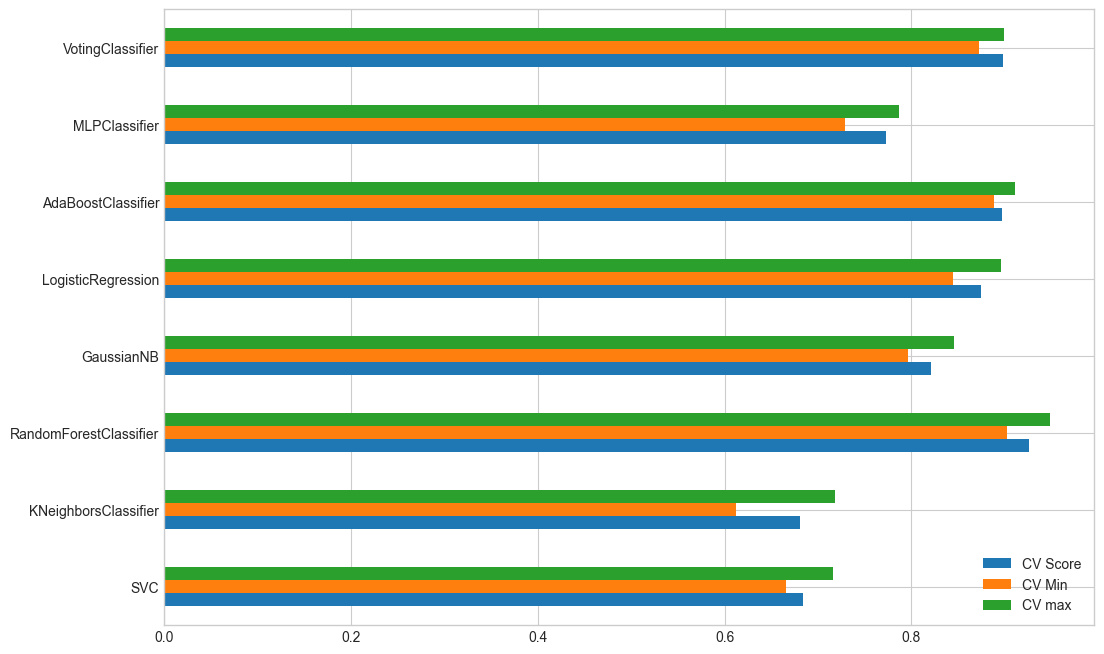

In [24]:
%%time
Benchmark(models,train_df[variables_selected],train_df[target_column],scoring='roc_auc')

### Ensemble method with no outliers

Now we are to test if training our models in the set with no outliers may benefit the cv overall performance.

Resuls show a better performance on this set so we are to move forward with this training approach.

In [25]:
train_df_no_outliers=train_df[outliers==1]

CPU times: user 33.8 s, sys: 6.95 s, total: 40.8 s
Wall time: 7.23 s


,CV Score,CV Min,CV max
SVC,0.709044,0.660802,0.765179
KNeighborsClassifier,0.674446,0.627497,0.707505
RandomForestClassifier,0.924198,0.903660,0.942901
GaussianNB,0.842443,0.811285,0.873860
LogisticRegression,0.895348,0.869339,0.920321
AdaBoostClassifier,0.907946,0.898555,0.926292
MLPClassifier,0.768156,0.790105,0.821863
VotingClassifier,0.910698,0.896818,0.927269


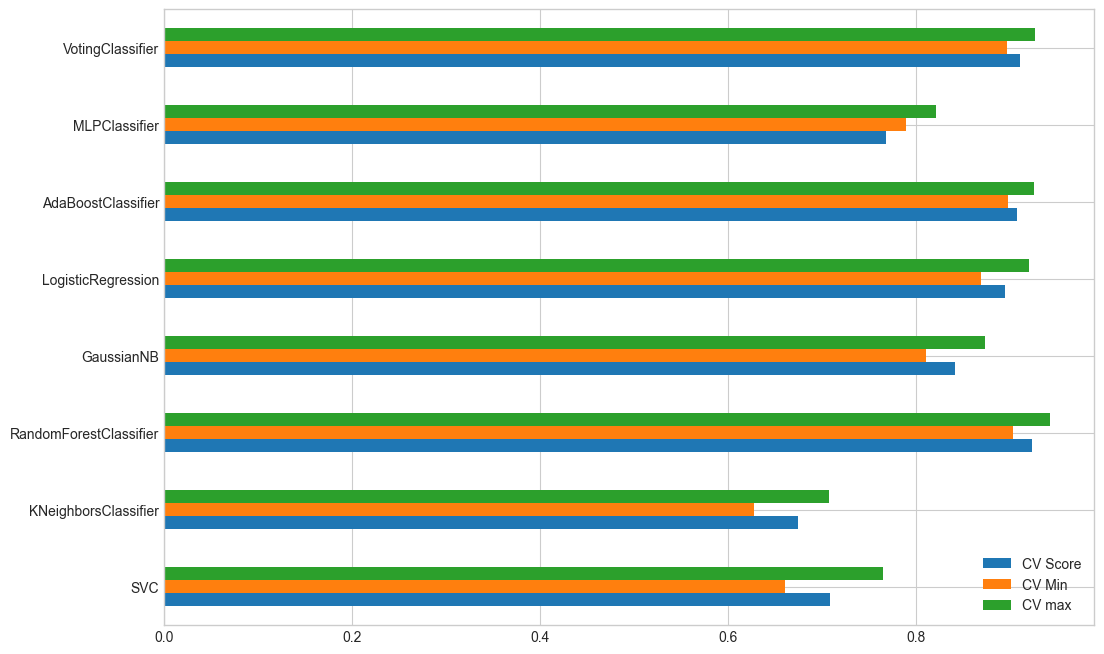

In [26]:
%%time
Benchmark(models,
          train_df_no_outliers[variables_selected],
          train_df_no_outliers[target_column],
          scoring='roc_auc'
         )

In [27]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

#### Hyperopt

We are to use the best model and tune the hyperparameters using GridSearch. This approach is not recommended due to it is exhaustive but in this case we have a small dataset so it may be worth exploring the full search space.

In [28]:
%%time
params={'nnet__activation':['identity', 'logistic', 'tanh', 'relu'],
        'nnet__alpha':np.arange(.0001,.1,.05),
        'nnet__learning_rate':['constant', 'invscaling', 'adaptive'],
        'lr__C':np.arange(.01,1,.5),
        'rf__n_estimators':[150,250],
        'rf__criterion':['gini','entropy']
       }

grid=GridSearchCV(estimator=Voting,
                  param_grid=params,
                  scoring='roc_auc',
                  cv=2
                 ).fit(train_df_no_outliers[variables_selected], train_df_no_outliers[target_column])

CPU times: user 13min 38s, sys: 4min 5s, total: 17min 43s
Wall time: 2min 22s


### Model evaluation
Roc auc score is chosen for evaluating model's performance for two main reasons:
1. Is easy to interprate and it is robust when triying to minimize false positives
2. It has become an standard on credit risk industry.
3. It is unsentive to class balance and among other benefits, it implies that two models may be compared under this metric regardless of the dataset target class change. This holds not true for explample for PR curve.

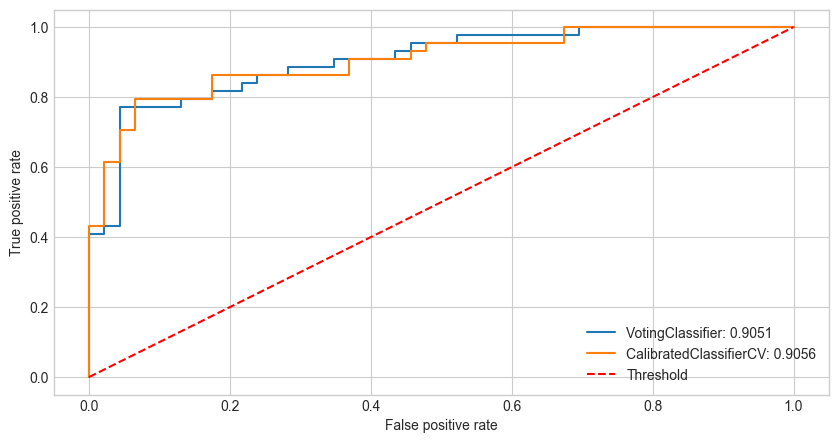

In [29]:
clfs = [grid.best_estimator_, CalibratedClassifierCV(base_estimator=grid.best_estimator_,method='sigmoid')]
ROCs(clfs,test_df[variables_selected],test_df[target_column])

In [30]:
final_model=CalibratedClassifierCV(base_estimator=grid.best_estimator_,
                                   method='sigmoid',
                                   cv=3).fit(train_df[variables_selected],train_df[target_column])

predictions=final_model.predict_proba(test_df[variables_selected])[:,1]

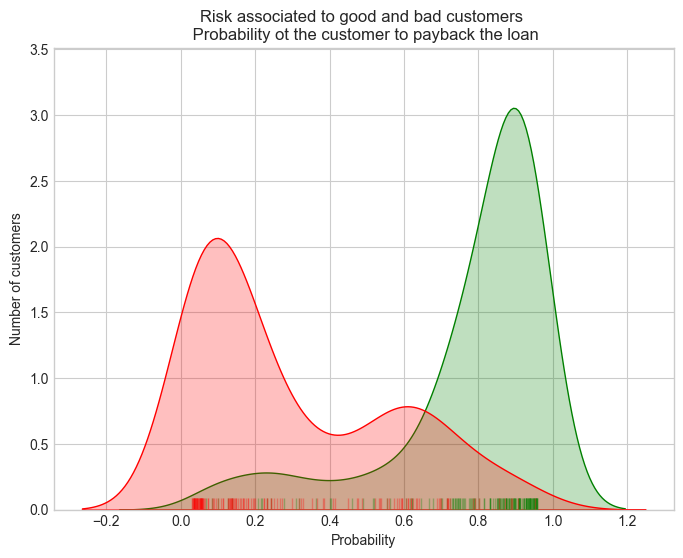

In [31]:
RiskPlot(test_df.assign(**{"predictions":predictions}),'predictions','clase')

## Deployment


### Credit line estimation

To determine the credit line we are to take euristics approach as follows:

1. We are going to split the population in customers and non customers
2. We are to check the difference in risk between the two and assign x% more line to customers.
3. We are to use then a 1.x factor by the risk times the montlhy income as credit line

With this rules:

a. Konfio customers will be authorized  at most with 1.3x
b. Non customers will be authorized with 1.0x



In [32]:
# Average risk by Konfio's already and non clients
train_df.groupby("cliente_konfio")[target_column].mean().to_frame()

,clase
cliente_konfio,
0.0,0.530211
1.0,0.684211


In [33]:
train_df.loc[:,"risk_factor"] = cross_val_predict(final_model, train_df[variables_selected], train_df[target_column],method = "predict_proba")[:,1]
test_df.loc[:,"risk_factor"] = final_model.predict_proba(test_df[variables_selected])[:,1]

df_profiling = pd.concat([train_df, test_df], ignore_index=True)

In [34]:
f1 = 1
f2 = 1.3
df_profiling.loc[:,"max_authorized_loan"] = np.where(df_profiling.cliente_konfio == 1,
                                                     df_profiling.income * (1 - df_profiling.risk_factor) * f2,
                                                     df_profiling.income * (1 - df_profiling.risk_factor) * f1)

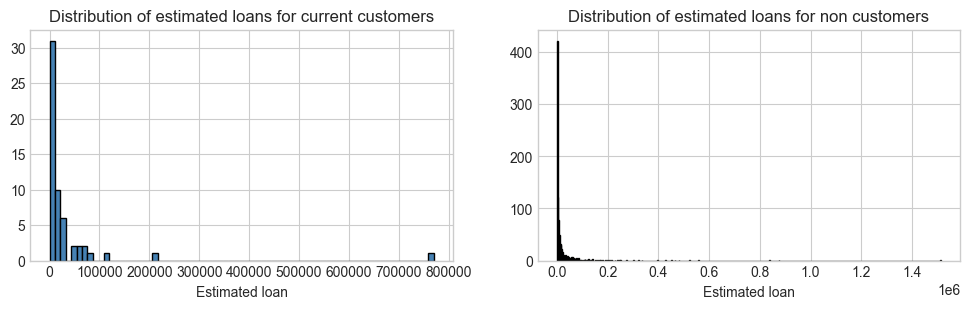

In [35]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
df_profiling[df_profiling.cliente_konfio == 1].max_authorized_loan.hist(bins="auto",color='steelblue',edgecolor='black');
plt.title('Distribution of estimated loans for current customers')
plt.xlabel('Estimated loan')
plt.subplot(1,2,2)
df_profiling[df_profiling.cliente_konfio == 0].max_authorized_loan.hist(bins="auto",color='olive',edgecolor='black');
plt.title('Distribution of estimated loans for non customers')
plt.xlabel('Estimated loan');

### Interest rate estimation

After asting to Konfio's stakeholders, we  know that rate of interest lies between  ```28% - 59%``` so the customers with a higher risk will have a smaller rate. 

With this in mind we are going to train a neural net to predict values between the range ```(28%,59%)``` based on risk factor calculated previously with our classifier model.

The MLP will be an approach to interpolate the interest rate givent the estimated risk.

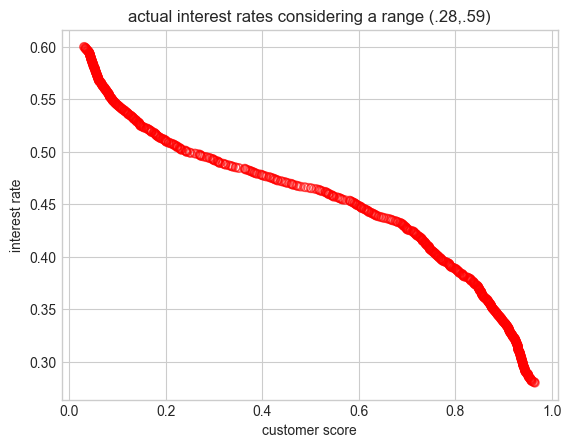

In [36]:
axis=np.linspace(start=.28,stop=.60,num=df_profiling.shape[0])
plt.scatter(y=axis,
            x=df_profiling.risk_factor.sort_values(ascending=False),
            facecolor='none',
            edgecolor='red',
            alpha=.5
           )
plt.xlabel('customer score')
plt.ylabel('interest rate');
plt.title('actual interest rates considering a range (.28,.59)');

In [37]:
n=df_profiling.shape[0]
x=df_profiling.risk_factor.sort_values(ascending=False)
y=axis
X = np.reshape(x ,[n, 1]) 
y = np.reshape(y ,[n ,])
modelo =MLPRegressor(hidden_layer_sizes=(1000,500,2000,1000,1000)).fit(X,y) 

In [38]:
predicted_rate=modelo.predict(np.reshape(df_profiling.risk_factor,[n, 1]))
df_profiling.loc[:,'estimated_interest_rate']=predicted_rate

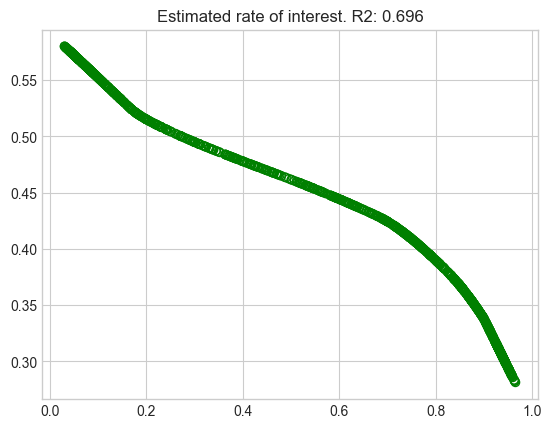

In [39]:
r2 = abs(r2_score(df_profiling["risk_factor"], df_profiling["estimated_interest_rate"]))

plt.scatter(data=df_profiling,
            x='risk_factor',
            y='estimated_interest_rate',
            facecolor='none',
            edgecolor='green'
           )
plt.title(f'Estimated rate of interest. R2: {round(r2,3)}');

### Term estimation

Finally to calculate loan's term we are going to apply the following formula: ```n= C/(P-C x i)``` such that:
1. **n:** term of payments to be estimated
2. **C:** maximum_authorized amount (previously calculated)
3. **P:** 10% of monthly income, this comes because 'ratio' for the 75% of the customers is below 11% so this is the percentage that a customer can affort as new debt*


In [40]:
df_profiling.loc[:,'loan_term_months']= df_profiling.max_authorized_loan/(df_profiling.income*.10-df_profiling.max_authorized_loan*(df_profiling.estimated_interest_rate/12))

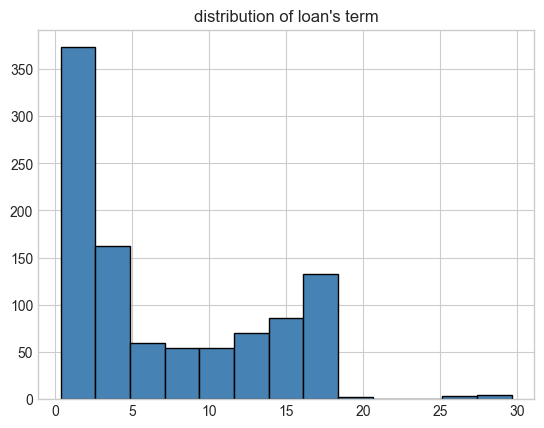

In [41]:
df_profiling.loan_term_months.hist(bins="auto",color='steelblue',edgecolor='black')
plt.title("distribution of loan's term");

### Putting all together

Finally we are on position to provide a table for the 524 approved customersones wich contains all the information needed for credit line assigment, interest rate and term.


In [42]:
df_profiling[['risk_factor','max_authorized_loan','loan_term_months', 'estimated_interest_rate']].sample(7)

,risk_factor,max_authorized_loan,loan_term_months,estimated_interest_rate
260,0.853518,648.037184,1.533242,0.365570
776,0.036164,14059.476880,17.985794,0.577832
855,0.749883,65.530548,2.734174,0.408868
322,0.507281,65.531573,6.075569,0.460344
146,0.596491,41700.217398,4.744711,0.444780
24,0.781227,421.795017,2.358527,0.397208
75,0.169554,1572.865014,13.029133,0.523993


In [43]:
path = "data/response.pkl"
df_profiling[['risk_factor','max_authorized_loan','loan_term_months', 'estimated_interest_rate']].to_pickle(path)